<a href="https://colab.research.google.com/github/jiwon-hae/3d2n_ann/blob/develop/Accurate_labelling_of_pointclouds_with_semantic_labels_using_images_JiwonHae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Request 5#


Description: You are given a set of images and pointclouds. We also provided code for the processes mentioned in this description like selecting closest image to every pointcloud and projecting the pointcloud to the image. Extract semantic labels of the image using Grounded SAM. Create a folder named output, which contains directories, corresponding to every pointcloud, with the filename as the timestamp of that pointcloud. In each of that directory you need to have the pointcloud that is stored as cloud.pcd and the label for every voxel (equivalent of pixel in the 3D pointcloud). The format of the label file can be any choice. Transform semantic labels of the images (2D semantic labels) through Grounded SAM, to the pointcloud (3D semantic labels). Hint: Remember that we have data from 5 cameras that have some overlap, ontop of that these cameras keep recording stream of images. Given a 3D point in a scene, there are many images that capture it, can you make use of all these labels to deduce an accurate label of that 3D point?

Github Issue link: https://github.com/klekkala/3d2d_ann/issues/1

Input folder: gsam_labels/{16234.23423}/{label files}, imgs/{16234.23423}.png, pcl/{152342.23545234}.pcd}

Output folder: kitti semantic

In [ ]:
#Use the 3D to 2D projection code on github, then label it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/USCilab3D/data/lt_dataset

Mounted at /content/drive
/content/drive/MyDrive/USCilab3D/data/lt_dataset


In [ ]:
#You may have do some modifications here

import os
import sys
import re

def find_closest_file(input_filename):
    match = re.search(r'(\d+)', input_filename)
    if not match:
        raise ValueError("Input filename does not contain a numeric part.")

    numeric_part = int(match.group(1))

    lb3_folders = ['./lb3/Cam0', './lb3/Cam1', './lb3/Cam2', './lb3/Cam4', './lb3/Cam5']

    closest_filename = None
    closest_difference = float('inf')

    files_in_folder = os.listdir(lb3_folders[0])


    for file_in_folder in files_in_folder:
        match_folder = re.search(r'(\d+)', file_in_folder)
        if not match_folder:
            continue

        numeric_folder = int(match_folder.group(1))
        difference = abs(numeric_folder - numeric_part)

        if difference < closest_difference:
            closest_difference = difference
            closest_filename = os.path.join(lb3_folders[0], file_in_folder)

    if closest_filename is None:
        raise FileNotFoundError("No matching file found in the lb3 folders.")

    return [os.path.join(folder, closest_filename.split('/')[-1]) for folder in lb3_folders]

# Example usage
input_filename = './velodyne_sync/'+'1326036598034801'+'.bin'
result = find_closest_file(input_filename)
print(result)


['./lb3/Cam0/1326036598034801.tiff', './lb3/Cam1/1326036598034801.tiff', './lb3/Cam2/1326036598034801.tiff', './lb3/Cam4/1326036598034801.tiff', './lb3/Cam5/1326036598034801.tiff']


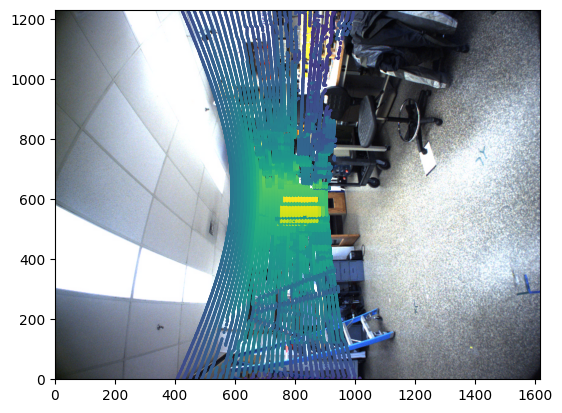

0

In [ ]:
# !/usr/bin/python
# You may have do some modifications here
#
# Demonstrates how to project velodyne points to camera imagery. Requires a binary
# velodyne sync file, undistorted image, and assumes that the calibration files are
# in the directory.
#
# To use:
#
#    python project_vel_to_cam.py vel img cam_num
#
#       vel:  The velodyne binary file (timestamp.bin)
#       img:  The undistorted image (timestamp.tiff)
#   cam_num:  The index (0 through 5) of the camera
#

import sys
import struct
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

#from undistort import *

def convert(x_s, y_s, z_s):

    scaling = 0.005 # 5 mm
    offset = -100.0

    x = x_s * scaling + offset
    y = y_s * scaling + offset
    z = z_s * scaling + offset

    return x, y, z

def load_vel_hits(filename):

    f_bin = open(filename, "rb")

    hits = []

    while True:

        x_str = f_bin.read(2)
        if x_str == b'': # eof
            break
        x = struct.unpack('<H', x_str)[0]
        y = struct.unpack('<H', f_bin.read(2))[0]
        z = struct.unpack('<H', f_bin.read(2))[0]
        i = struct.unpack('B', f_bin.read(1))[0]
        l = struct.unpack('B', f_bin.read(1))[0]

        x, y, z = convert(x, y, z)

        # Load in homogenous
        hits += [[x, y, z, 1]]

    f_bin.close()
    hits = np.asarray(hits)

    return hits.transpose()

def ssc_to_homo(ssc):

    # Convert 6-DOF ssc coordinate transformation to 4x4 homogeneous matrix
    # transformation

    sr = np.sin(np.pi/180.0 * ssc[3])
    cr = np.cos(np.pi/180.0 * ssc[3])

    sp = np.sin(np.pi/180.0 * ssc[4])
    cp = np.cos(np.pi/180.0 * ssc[4])

    sh = np.sin(np.pi/180.0 * ssc[5])
    ch = np.cos(np.pi/180.0 * ssc[5])

    H = np.zeros((4, 4))

    H[0, 0] = ch*cp
    H[0, 1] = -sh*cr + ch*sp*sr
    H[0, 2] = sh*sr + ch*sp*cr
    H[1, 0] = sh*cp
    H[1, 1] = ch*cr + sh*sp*sr
    H[1, 2] = -ch*sr + sh*sp*cr
    H[2, 0] = -sp
    H[2, 1] = cp*sr
    H[2, 2] = cp*cr

    H[0, 3] = ssc[0]
    H[1, 3] = ssc[1]
    H[2, 3] = ssc[2]

    H[3, 3] = 1

    return H

def project_vel_to_cam(hits, cam_num):

    # Load camera parameters
    K = np.loadtxt('K_cam%d.csv' % (cam_num), delimiter=',')
    x_lb3_c = np.loadtxt('x_lb3_c%d.csv' % (cam_num), delimiter=',')

    # Other coordinate transforms we need
    x_body_lb3 = [0.035, 0.002, -1.23, -179.93, -0.23, 0.50]

    # Now do the projection
    T_lb3_c = ssc_to_homo(x_lb3_c)
    T_body_lb3 = ssc_to_homo(x_body_lb3)

    T_lb3_body = np.linalg.inv(T_body_lb3)
    T_c_lb3 = np.linalg.inv(T_lb3_c)

    T_c_body = np.matmul(T_c_lb3, T_lb3_body)

    hits_c = np.matmul(T_c_body, hits)
    hits_im = np.matmul(K, hits_c[0:3, :])

    return hits_im

def project(vel, img, cam_num):



    # Load velodyne points
    hits_body = load_vel_hits(vel)

    # Load image
    image = mpimg.imread(img)

    cam_num = int(cam_num)

    hits_image = project_vel_to_cam(hits_body, cam_num)

    x_im = hits_image[0, :]/hits_image[2, :]
    y_im = hits_image[1, :]/hits_image[2, :]
    z_im = hits_image[2, :]

    idx_infront = z_im>0
    x_im = x_im[idx_infront]
    y_im = y_im[idx_infront]
    z_im = z_im[idx_infront]

    plt.figure(1)
    plt.imshow(image)
    plt.scatter(x_im, y_im, c=z_im, s=5, linewidths=0)
    plt.xlim(0, 1616)
    plt.ylim(0, 1232)
    plt.show()

    return 0

project('./velodyne_sync/1326036598034801.bin','./lb3/Cam1/1326036598034801.tiff',1)

In [ ]:
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything